<a href="https://colab.research.google.com/github/CRosero/aml-project/blob/master/FDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing the dataset from drive.
( You can find the zipped folder [here](https://drive.google.com/file/d/1XsRmyQYHfgRFJCOueXpJ37yyOCrKHO-W/view?usp=sharing))

In [63]:
# Mount Google Drive
from google.colab import drive
import os

drive.mount('/gdrive/')
data_path = "/content/data"

use_complete_dataset = False


if (use_complete_dataset == True) and (not os.path.isfile('/content/data.zip')):
  print("download entire dataset")
  !gdown --id 1A2dBwPlCyXHTqmG1LRvPfVm6K21jWwUI # 3-5 min
  !jar xf  "/content/data.zip"
elif (use_complete_dataset == False) and (not os.path.isfile('/content/data.zip')):
  # Load cropped dataset containing only 10 images
  print("download cropped dataset")
  !gdown --id 1gPcwDJsNpyqcjKu225hnIxkURpjUA08i   
  !jar xf  "/content/data.zip"
else:
  print("dataset already downloaded")

if not os.path.isdir('/content/data'):
  print("Dataset doesn't exist")

Drive already mounted at /gdrive/; to attempt to forcibly remount, call drive.mount("/gdrive/", force_remount=True).
dataset already downloaded


# Cloning the repository from github

In [64]:
# Clone the entire repo.
repo_path = "/content/cloned-repo"
if not os.path.isdir(repo_path):
  !git clone -l -s https://github.com/CRosero/aml-project.git cloned-repo
  %cd cloned-repo
else:
  print("Repository already cloned")
%cd /content/cloned-repo
!ls

Repository already cloned
/content/cloned-repo
 dataset        runs
 demo_images    train.py
 eval.ipynb     train_step_2-experiment.ipynb
 eval.py        train_step_2.ipynb
 image_output   train_step_3.ipynb
 loss.py        train_step_4.FDA_TENSOR.ipynb
 model	        train_step_4.ipynb
 __pycache__   'Train using corrected input size'
 README.md      utils.py


# Importing the libraries

In [65]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
import torch
from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim
import torch.cuda.amp as amp

import torchvision
from torchvision.transforms import InterpolationMode
from torch.utils import data
import torch.nn.functional as F


from utils.utils import reverse_one_hot, compute_global_accuracy, fast_hist, per_class_iu, colour_code_segmentation,poly_lr_scheduler
from utils.loss import CrossEntropy2d,DiceLoss
import numpy as np
import os
import os.path as osp
import random
import matplotlib.pyplot as plt
import collections
from PIL import Image
#from torchinfo import summary
#from fvcore.nn import FlopCountAnalysis
import json
import argparse
from tqdm import tqdm

# Dataset class:
from dataset.cityscapesDataSet import cityscapesDataSet
from dataset.GTA5DataSet import GTA5DataSet
# Discriminator
from model.discriminator import FCDiscriminator, LightWeightFCDiscriminator
# Network
from model.build_BiSeNet import BiSeNet

## FDA Demo

In [66]:
def extract_ampl_phase(fft_im):
    # fft_im: size should be b x 3 x h x w dtype= cfloat see:https://pytorch.org/docs/stable/complex_numbers.html
    fft_amp = fft_im.real**2 + fft_im.imag**2
    fft_amp = torch.sqrt(fft_amp)
    fft_pha = torch.atan2( fft_im.imag, fft_im.real)
    return fft_amp, fft_pha

def low_freq_mutate( amp_src, amp_trg, L=0.1 ):
    _, _, h, w = amp_src.size() #amp_src shape: b x 3 x h x w
    b = (  np.floor(np.amin((h,w))*L)  ).astype(int)     # get b
    amp_src[:,:,0:b,0:b]     = amp_trg[:,:,0:b,0:b]      # top left
    amp_src[:,:,0:b,w-b:w]   = amp_trg[:,:,0:b,w-b:w]    # top right
    amp_src[:,:,h-b:h,0:b]   = amp_trg[:,:,h-b:h,0:b]    # bottom left
    amp_src[:,:,h-b:h,w-b:w] = amp_trg[:,:,h-b:h,w-b:w]  # bottom right
    return amp_src


def low_freq_mutate_np_original( amp_src, amp_trg, L=0.1 ): #ORIGINAL, BUG!!
   
    a_src = np.fft.fftshift( amp_src, axes=(-2, -1) )
    a_trg = np.fft.fftshift( amp_trg, axes=(-2, -1) )

    _, h, w = a_src.shape
    b = (  np.floor(np.amin((h,w))*L)  ).astype(int)
    c_h = np.floor(h/2.0).astype(int)
    c_w = np.floor(w/2.0).astype(int)

    h1 = c_h-b
    h2 = c_h+b+1
    w1 = c_w-b
    w2 = c_w+b+1

    a_src[:,h1:h2,w1:w2] = a_trg[:,h1:h2,w1:w2]
    a_src = np.fft.ifftshift( a_src, axes=(-2, -1) )
    
    return a_src

def low_freq_mutate_np( amp_src, amp_trg, L=0.1 ):
    '''
    a_src = np.fft.fftshift( amp_src, axes=(-2, -1) )
    a_trg = np.fft.fftshift( amp_trg, axes=(-2, -1) )

    _, h, w = a_src.shape
    b = (  np.floor(np.amin((h,w))*L)  ).astype(int)
    c_h = np.floor(h/2.0).astype(int)
    c_w = np.floor(w/2.0).astype(int)

    h1 = c_h-b
    h2 = c_h+b+1
    w1 = c_w-b
    w2 = c_w+b+1

    a_src[:,h1:h2,w1:w2] = a_trg[:,h1:h2,w1:w2]
    a_src = np.fft.ifftshift( a_src, axes=(-2, -1) )
    

    return a_src
    '''
    _, h, w = amp_src.shape
    b = (  np.floor(np.amin((h,w))*L)  ).astype(int)     # get b
    amp_src[:,0:b,0:b]     = amp_trg[:,0:b,0:b]      # top left
    amp_src[:,0:b,w-b:w]   = amp_trg[:,0:b,w-b:w]    # top right
    amp_src[:,h-b:h,0:b]   = amp_trg[:,h-b:h,0:b]    # bottom left
    amp_src[:,h-b:h,w-b:w] = amp_trg[:,h-b:h,w-b:w]  # bottom right
    return amp_src
    


def FDA_source_to_target(src_img, trg_img, L=0.1):
    # exchange magnitude
    # input: src_img, trg_img
    # input: tensors

    # get fft of both source and target
    fft_src = torch.fft.fft2( src_img.clone()) # output: complex tensor b x 3 x h x w
    fft_trg = torch.fft.fft2( trg_img.clone()) # output: complex tensor b x 3 x h x w

    # extract amplitude and phase of both ffts
    amp_src, pha_src = extract_ampl_phase( fft_src.clone())
    amp_trg, pha_trg = extract_ampl_phase( fft_trg.clone())

    # replace the low frequency amplitude part of source with that from target
    amp_src_ = low_freq_mutate( amp_src.clone(), amp_trg.clone(), L=L )

    # recompose fft of source # z=r(cosφ+isinφ).r is the magnitude, and φ is the phase.
    real = torch.cos(pha_src.clone()) * amp_src_.clone()
    imag = torch.sin(pha_src.clone()) * amp_src_.clone()
    fft_src_=torch.complex(real, imag)

    # get the recomposed image: source content, target style
    src_in_trg = torch.fft.ifft2( fft_src_ )
    src_in_trg = src_in_trg.real # extract the real part (the complex one is 0)

    return src_in_trg

def FDA_source_to_target_np( src_img, trg_img, L=0.1 ):
    # exchange magnitude
    # input: src_img, trg_img

    src_img_np = src_img #.cpu().numpy()
    trg_img_np = trg_img #.cpu().numpy()

    # get fft of both source and target
    fft_src_np = np.fft.fft2( src_img_np, axes=(-2, -1) )
    fft_trg_np = np.fft.fft2( trg_img_np, axes=(-2, -1) )
    #return fft_src_np

    # extract amplitude and phase of both ffts
    amp_src, pha_src = np.abs(fft_src_np), np.angle(fft_src_np)
    amp_trg, pha_trg = np.abs(fft_trg_np), np.angle(fft_trg_np)

    # mutate the amplitude part of source with target
    amp_src_ = low_freq_mutate_np( amp_src, amp_trg, L=L )

    # mutated fft of source
    fft_src_ = amp_src_ * np.exp( 1j * pha_src )

    # get the mutated image
    src_in_trg = np.fft.ifft2( fft_src_, axes=(-2, -1) )
    src_in_trg = np.real(src_in_trg) # extract the real part (the complex one is 0)

    return src_in_trg




In [67]:
def print_solutions(im_src, im_trg, src_in_trg, RGB = True):


  src_in_trg = np.array((src_in_trg - src_in_trg.min()) * 255.0 /
                      (src_in_trg.max() - src_in_trg.min()), np.uint8)
  im_src = np.array((im_src - im_src.min()) * 255.0 /
                      (im_src.max() - im_src.min()), np.uint8)
  im_trg= np.array((im_trg - im_trg.min()) * 255.0 /
                      (im_trg.max() - im_trg.min()), np.uint8)

  src_in_trg = src_in_trg.transpose((1,2,0)) #from channels, heidth, width ->heidth, width, channels
  im_src = im_src.transpose((1,2,0))
  im_trg = im_trg.transpose((1,2,0))
  
  if (not RGB): 
    im_src = im_src[:,:,::-1]
    im_trg = im_trg[:,:,::-1]
    src_in_trg = src_in_trg[:,:,::-1]
  
  src_in_trg = Image.fromarray(src_in_trg,mode="RGB")
  im_src = Image.fromarray(im_src,mode="RGB")
  im_trg = Image.fromarray(im_trg,mode="RGB")

  ### PRINT RESULTS ###
  images = [im_src,im_trg ,src_in_trg]
  titles = ["Source (GTA)", "Target (Cityscapes)", "Source image in target style"]
  plt.figure(figsize=(20,10))
  columns = len(images)
  for i, image in enumerate(images):
      plt.subplot(len(images) / columns + 1, columns, i + 1)
      plt.title(titles[i])
      plt.imshow(image)

In [75]:
#DEMO TENSORS+

L=0.01
# get fft of both source and target

src_img = torch.Tensor(np.arange(0,60).reshape((3,4,5)))
trg_img = torch.Tensor(np.arange(60,120).reshape((3,4,5)))

src_img = torch.unsqueeze(src_img, 0)
trg_img = torch.unsqueeze(trg_img, 0)

fft_src = torch.fft.fft2( src_img.clone()) # output: complex tensor b x 3 x h x w
fft_trg = torch.fft.fft2( trg_img.clone()) # output: complex tensor b x 3 x h x w
# extract amplitude and phase of both ffts
amp_src, pha_src = extract_ampl_phase( fft_src.clone())
amp_trg, pha_trg = extract_ampl_phase( fft_trg.clone())
# replace the low frequency amplitude part of source with that from target
amp_src_ = low_freq_mutate( amp_src.clone(), amp_trg.clone(), L=L )

real = torch.cos(pha_src.clone()) * amp_src_.clone()
imag = torch.sin(pha_src.clone()) * amp_src_.clone()
fft_src_=torch.complex(real, imag)

src_in_trg = torch.fft.ifft2( fft_src_ )
src_in_trg = src_in_trg.real
low_freq_mutate( src_img.clone(), trg_img.clone(), L=0 )

tensor([[[[ 0.,  1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.,  9.],
          [10., 11., 12., 13., 14.],
          [15., 16., 17., 18., 19.]],

         [[20., 21., 22., 23., 24.],
          [25., 26., 27., 28., 29.],
          [30., 31., 32., 33., 34.],
          [35., 36., 37., 38., 39.]],

         [[40., 41., 42., 43., 44.],
          [45., 46., 47., 48., 49.],
          [50., 51., 52., 53., 54.],
          [55., 56., 57., 58., 59.]]]])

In [74]:
# DEMO numpy

L = 0.01
src_img_np = np.arange(0,60).reshape((3,4,5))
trg_img_np = np.arange(60,120).reshape((3,4,5))

# get fft of both source and target
fft_src_np = np.fft.fft2( src_img_np, axes=(-2, -1) )
fft_trg_np = np.fft.fft2( trg_img_np, axes=(-2, -1) )

# extract amplitude and phase of both ffts
amp_src, pha_src = np.abs(fft_src_np), np.angle(fft_src_np)
amp_trg, pha_trg = np.abs(fft_trg_np), np.angle(fft_trg_np)

# mutate the amplitude part of source with target
amp_src_ = low_freq_mutate_np( amp_src, amp_trg, L=L )

# mutated fft of source
fft_src_ = amp_src_ * np.exp( 1j * pha_src )

# get the mutated image
src_in_trg = np.fft.ifft2( fft_src_, axes=(-2, -1) )
src_in_trg = np.real(src_in_trg)

print(low_freq_mutate_np( src_img_np, trg_img_np, L=0 ))
print("Original:")
print(low_freq_mutate_np_original( src_img_np, trg_img_np, L=0 ) )

[[[ 0  1  2  3  4]
  [ 5  6  7  8  9]
  [10 11 12 13 14]
  [15 16 17 18 19]]

 [[20 21 22 23 24]
  [25 26 27 28 29]
  [30 31 32 33 34]
  [35 36 37 38 39]]

 [[40 41 42 43 44]
  [45 46 47 48 49]
  [50 51 52 53 54]
  [55 56 57 58 59]]]
Original:
[[[ 60   1   2   3   4]
  [  5   6   7   8   9]
  [ 10  11  12  13  14]
  [ 15  16  17  18  19]]

 [[ 80  21  22  23  24]
  [ 25  26  27  28  29]
  [ 30  31  32  33  34]
  [ 35  36  37  38  39]]

 [[100  41  42  43  44]
  [ 45  46  47  48  49]
  [ 50  51  52  53  54]
  [ 55  56  57  58  59]]]


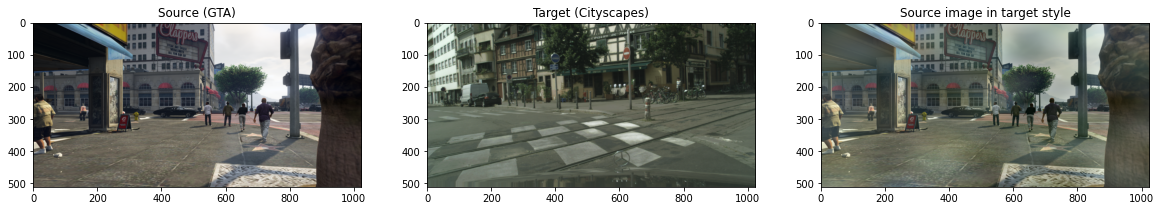

In [70]:
#DEMO TENSORS+
data_dir ="/content/data"
source_data_root_path = os.path.join(data_dir, "GTA5") # /content/data/GTA5
target_data_root_path = os.path.join(data_dir, "Cityscapes") # /content/data/Cityscapes
source_train_path = os.path.join(source_data_root_path, "train.txt") # /content/data/GTA5/train.txt
target_root_path = os.path.join(target_data_root_path,  "train.txt")   # /content/data/Cityscapes/train.txt
info_path = os.path.join(source_data_root_path,  "info.json") # /content/data/GTA/info.json 
IMG_MEAN = np.array((0, 0, 0), dtype=np.float32)
info_json = json.load(open(info_path))
input_size = (1024,512)
source_dataset = GTA5DataSet(source_data_root_path, source_train_path, info_json, crop_size = input_size, mean=IMG_MEAN)
target_dataset = cityscapesDataSet(target_data_root_path, target_root_path, info_json, crop_size = input_size, mean=IMG_MEAN)

# Create DataLoaders
trainloader = data.DataLoader(source_dataset, batch_size=1, shuffle=False, num_workers=8, pin_memory=True)
trainloader_iter = enumerate(trainloader)
targetloader = data.DataLoader(target_dataset, batch_size=1, shuffle=False, num_workers=8, pin_memory=True)
targetloader_iter = enumerate(targetloader)

_ , (im_src,_) =next(trainloader_iter)
_ , (im_trg,_) =next(targetloader_iter)

src_in_trg = FDA_source_to_target( im_src, im_trg, L=0.01 )


src_in_trg = torch.squeeze( src_in_trg)
im_src = torch.squeeze(im_src)
im_trg = torch.squeeze(im_trg)


print_solutions(im_src, im_trg, src_in_trg, RGB = False)


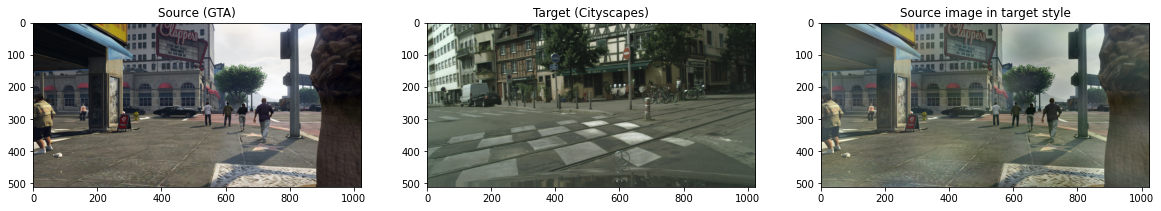

In [71]:
import numpy as np
from PIL import Image
#from utils import FDA_source_to_target_np
import scipy.misc

im_src = Image.open("/content/data/GTA5/images/08688.png").convert('RGB')
im_trg = Image.open("/content/data/Cityscapes/images/strasbourg_000000_017593_leftImg8bit.png").convert('RGB')

im_src = im_src.resize( (1024,512), Image.BICUBIC )
im_trg = im_trg.resize( (1024,512), Image.BICUBIC )

im_src = np.asarray(im_src, np.float32)
im_trg = np.asarray(im_trg, np.float32)

im_src = im_src.transpose((2, 0, 1))
im_trg = im_trg.transpose((2, 0, 1))

src_in_trg = FDA_source_to_target_np( im_src, im_trg, L=0.01) # 3,512,1024

print_solutions(im_src, im_trg, src_in_trg, RGB = True)